# Homework 1 (Income Prediction)

The goal of this assignment is to predict whether an individual makes more or less than $50,000 given demographic data. A data dictionary was provided:  

age: continuous.  
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.  
fnlwgt: continuous.  
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  
education-num: continuous.  
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.  
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.  
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.  
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.  
sex: Female, Male.  
capital-gain: continuous.  
capital-loss: continuous.  
hours-per-week: continuous.  
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. 

In [ ]:
# analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import models
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import sklearn
from sklearn import compose
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import warnings
import tensorflow as tf

### EDA

In [ ]:
# read training data from .csv
trainDF = pd.read_csv('./adult.csv')

# drop id column (wont be used for modeling)
trainDF.drop('id', axis = 1, inplace = True)

# check data frame dimension
display(trainDF.shape)

# peek at data
display(trainDF.head())

# check data types
display(trainDF.info())

# check for missing data
display(trainDF.isna().sum())

### Numeric Predictors

In [ ]:
# summarize numeric data
display(trainDF.describe())

# suppress warnings
warnings.filterwarnings('ignore')

# numeric analysis function
def studyNumPredictor(pred):
    # boxplot by income level
    plot = sns.boxplot(x = trainDF['income'], y = trainDF[pred])
    plot.set(xlabel = 'Income Level', title = f"{pred} Comparison")
    plt.show()

    # single logistic regression
    logFit = LogisticRegression().fit(np.array(trainDF[pred]).reshape(-1, 1), trainDF['income'])
    logFit = sm.Logit(pd.get_dummies(trainDF['income'])['>50K'], trainDF[pred]).fit(disp = 0)
    display(logFit.pvalues)


# identify and study numeric predictors
findNumPredictors = make_column_selector(dtype_include = int)
for pred in trainDF[findNumPredictors].columns:
    studyNumPredictor(pred)

### Categorical Predictors

In [ ]:
# categorical analysis function
def studyCatPredictor(pred):
    # construct contingency table
    contingency = pd.crosstab(trainDF['income'], trainDF[pred])
    display(contingency)

    # chi squared test for independence
    print(f"Chi-squared test p-value: {stats.chi2_contingency(contingency)[1]}")

# identify and study categorical predictors
findCatPredictors = make_column_selector(dtype_include = object)
for pred in trainDF.drop('income', axis = 1, inplace = False)[findCatPredictors].columns:
    studyCatPredictor(pred)

### Model Preparation

In [ ]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_include = int)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((MinMaxScaler(), findNumPredictors),
                                    (OneHotEncoder(drop = 'first'), findCatPredictors))

# get new column names
colNames = transform.fit(trainDF).get_feature_names_out()

# transform data
modelDF = pd.DataFrame.sparse.from_spmatrix(transform.fit_transform(trainDF), columns = colNames)

# set random seed
np.random.seed(432023)

# split data into predictors and response
resp = modelDF['onehotencoder__income_>50K'].rename('income')
modelDF.drop('onehotencoder__income_>50K', axis = 1, inplace = True)

# split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(modelDF, resp, test_size = 0.2)

### Model Fitting

A KNN model using 9 neighbors achieved 83.12% cross-validation accuracy. 

In [ ]:
# set random seed
np.random.seed(482023)

# tune KNN model
Kvalues = range(1, 20)
knnFit = KNeighborsClassifier()
knnTune = GridSearchCV(knnFit,
                       param_grid = {'n_neighbors': Kvalues},
                       cv = 5,
                       n_jobs = -1,
                       verbose = 2)
knnTune.fit(modelDF, resp)
K = knnTune.best_params_['n_neighbors']

# fit KNN model
knnFit = KNeighborsClassifier(n_neighbors = K)
cvResults = cross_val_score(knnFit,
                            modelDF,
                            resp,
                            cv = 10,
                            n_jobs = -1)

# cross-validation accuracy
print(f"Neighbors considered: {K}")
print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

A random forest model using 17 features achieved 85.64% cross-validation accuracy.

In [ ]:
# set random seed
np.random.seed(432023)

# tune random forest model
Mvalues = range(1, 20)
rfFit = RandomForestClassifier()
rfTune = GridSearchCV(rfFit,
                      param_grid = {'max_features': Mvalues},
                      cv = 5,
                      n_jobs = -1)
rfTune.fit(modelDF, resp)
M = rfTune.best_params_['max_features']

# fit random forest model
rfFit = RandomForestClassifier(max_features = M,
                               n_estimators = 1000)
cvResults = cross_val_score(rfFit,
                            modelDF,
                            resp,
                            cv = 10,
                            n_jobs = -1)

# cross-validation accuracy
print(f"Features considered: {M}")
print(f"Cross-validation accuracy: {np.mean(cvResults).round(4)}")

In [46]:
# model fitting and evaluation function
def EvaluateModel(model, early = False, criteria = 'val_loss', opt = 'min'):
    # set random seed
    np.random.seed(462023)
    tf.random.set_seed(482023)

    # compile model
    model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

    # model summary
    model.summary()

    # number of epochs
    EPOCHS = 50

    if early:
        # early stopping criteria
        earlyStop = EarlyStopping(monitor = criteria, mode = opt, verbose = 1, patience = 3)

        # train model
        trained = model.fit(X_train, 
                            to_categorical(y_train), 
                            epochs = EPOCHS, 
                            batch_size = 128, 
                            validation_split = 0.2,
                            callbacks = earlyStop,
                            verbose = 1)
    else:
        # train model
        trained = model.fit(X_train, 
                            to_categorical(y_train), 
                            epochs = EPOCHS, 
                            batch_size = 128, 
                            validation_split = 0.2,
                            verbose = 1)

    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # plot training accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

A simple MLP with one hidden layer was fit using 50 epochs and a batch size of 128. This model achieved a training accuracy of 88.03% and a validation accuracy of 85.16%. This model displayed clear evidence of overfitting with validation accuracy flattening out after about 10 epochs. 

In [ ]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, False)

The previous model was expanded to include two hidden layers. This model achieved a training accuracy of 90.64% and a validation accuracy of 83.38%. This model alsodisplayed clear evidence of overfitting with validation accuracy decreasing after about 10 epochs. 

In [ ]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, False)

The original model was again expanded to include three hidden layers. This model achieved a training accuracy of 90.87% and a validation accuracy of 83.45%. This model also displayed clear evidence of overfitting with validation accuracy decreasing after about 10 epochs. 

In [47]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, False)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 512)               51712     
                                                                 
 dense_96 (Dense)            (None, 256)               131328    
                                                                 
 dense_97 (Dense)            (None, 128)               32896     
                                                                 
 dense_98 (Dense)            (None, 2)                 258       
                                                                 
Total params: 216,194
Trainable params: 216,194
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 3s 18ms/step - loss: 0.3703 - accuracy: 0.8261 - val_loss: 0.3464 - val_accuracy: 0.8380
Epoch 2/50
 33/163 [=====>..........

KeyboardInterrupt: 

Due to clear evidence of overfitting, an early stopping algorithm (based on validation loss) was applied to the original model with one hidden layer. Stopping after 7 epochs, this model achieved a training accuracy of 85.44% and a validation accuracy 85.14%.

In [ ]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True)

Another early stopping algorithm (based on validation accuracy) was applied to the original model with one hidden layer. Stopping after 11 epochs, this model achieved a training accuracy of 85.80% and a validation accuracy 84.89%.

In [ ]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True, 'val_accuracy', 'max')

An early stopping algorithm (based on validation loss) was applied to the MLP with three hidden layers. Stopping after 7 epochs, this model achieved a training accuracy of 85.94% and a valiation accuracy of 84.76%.

In [ ]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True)

Dropout regularization with a rate of 0.25 was applied to the MLP with three hidden layers. Stopping after 8 epochs, this model achieved a training accuracy of 85.65% and a validation accuracy of 85.18%.

In [ ]:
# dropout rate
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(rate = RATE),
    Dense(256, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(128, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(2, activation = 'sigmoid')
])

EvaluateModel(model, True)

Dropout regularization with a rate of 0.5 was applied to the MLP with three hidden layers. Stopping after 8 epochs, this model achieved a training accuracy of 84.95% and a validation accuracy of 84.64%.

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 512)               51712     
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_100 (Dense)           (None, 256)               131328    
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_101 (Dense)           (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_102 (Dense)           (None, 2)               

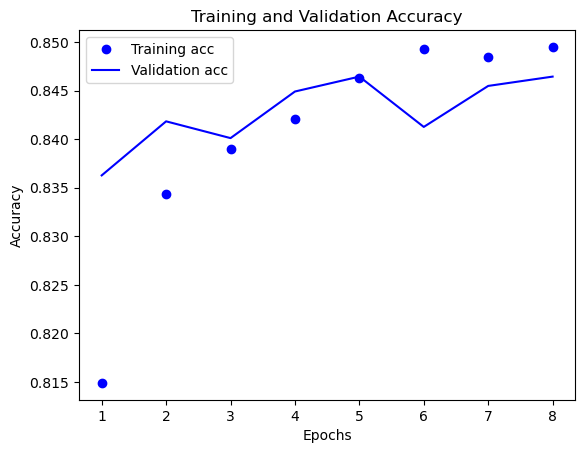

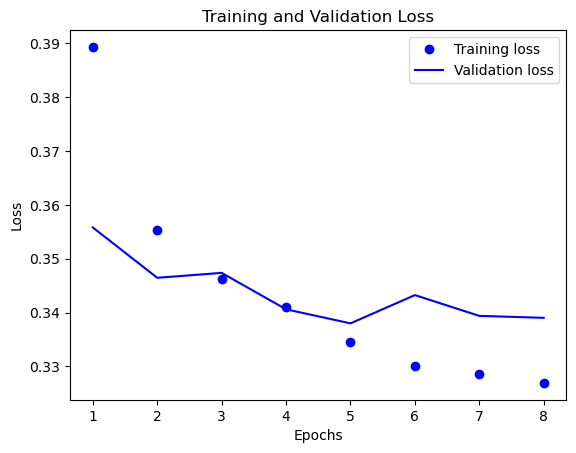

In [48]:
# dropout rate
RATE = 0.5

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(rate = RATE),
    Dense(256, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(128, activation = 'relu'),
    Dropout(rate = RATE),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True)

An L2 normalizing penalty (strenght of 0.001) was applied to the MLP with three hidden layers. Stopping after 27 epochs, this model achieved a training accuracy of 85.80% and a validation accuracy of 85.49%.

In [ ]:
# dropout rate
PENALTY = 0.001

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True)

An L2 normalizing penalty (strenght of 0.01) was applied to the MLP with three hidden layers. Stopping after 17 epochs, this model achieved a training accuracy of 83.53% and a validation accuracy of 83.69.

In [ ]:
# dropout rate
PENALTY = 0.01

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(2, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model, True)